# Exercício: Implementando Double DQN para CartPole

## 🎯 Olá, futuro(a) especialista em Aprendizado por Reforço!

Neste exercício, você vai mergulhar no mundo do Aprendizado por Reforço Profundo (Deep Reinforcement Learning) e construir seu próprio agente Double Deep Q-Network (DQN) para resolver o clássico problema do CartPole.

### O que é o CartPole?

O ambiente "CartPole-v1" do Gymnasium (antigo OpenAI Gym) é um problema de controle onde um carrinho se move em um trilho, e um pêndulo está preso a ele. O objetivo é manter o pêndulo na posição vertical aplicando forças para a esquerda ou para a direita no carrinho. É um ótimo ponto de partida para entender os fundamentos de RL.

### Como funciona este exercício?

1.  **Instruções Claras**: Cada seção explicará um conceito e o que você precisa fazer.
2.  **Sua Vez de Codificar**: Você encontrará células com a marcação `👨‍💻 Sua Vez de Codificar!` e um bloco de código para preencher.
3.  **Verificação Imediata**: Após cada codificação, haverá uma célula de teste. Basta executá-la para verificar sua implementação e receber feedback: `✅ Sucesso!` ou `❌ Falha`.
4.  **Solução Disponível**: Se ficar com dúvidas, você pode expandir a seção `👇 Solução Sugerida` para ver uma possível resposta.

Ao final, você terá a sensação de ter construído um agente de RL funcional e compreendido os princípios do Double DQN. Vamos começar!

## Parte 1: Configuração e Instalação de Dependências

Primeiro, vamos configurar nosso ambiente e instalar as bibliotecas necessárias. Execute a célula abaixo.

In [2]:
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!pip install gym[classic_control] > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu > /dev/null 2>&1

import warnings
warnings.filterwarnings("ignore")

import gym
import numpy as np
import os
import sys
import random
import torch
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns

# Gambiarra para fazer a versão antiga do Gym (que precisamos usar para
# conseguir usar o gerador de vídeos) funcionar com o NumPy mais recente.
np.bool8 = np.bool_

print("✅ Dependências instaladas e importadas com sucesso!")

✅ Dependências instaladas e importadas com sucesso!


## Parte 2: Funções Auxiliares para Visualização

Para visualizar o desempenho do nosso agente, precisaremos de algumas funções para renderizar e exibir vídeos do ambiente CartPole. Execute a célula abaixo para defini-las.

In [3]:
import glob
import io
import base64

from gym.wrappers import RecordVideo
from IPython.display import HTML
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display

# start virtual display
display = Display(visible=0, size=(1400, 900))
display.start()

# play recorded video
def show_video(episode_id=0):
    mp4list = glob.glob(f'video/rl-video-episode-*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[episode_id]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        ipythondisplay.display(HTML(data='''
            <video alt="test" autoplay loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
            </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")

print("✅ Funções de visualização prontas!")

✅ Funções de visualização prontas!


## Parte 3: Definição da Rede Neural (QNet)

A base do nosso agente DQN é uma rede neural que estima os valores Q (Q-values) para cada par estado-ação. Esta rede substituirá a tradicional tabela de Q-values em ambientes com espaços de estados contínuos ou muito grandes.

No Double DQN, usaremos duas instâncias dessa rede: uma "rede atual" (current network) que é treinada a cada passo, e uma "rede alvo" (target network) que é atualizada periodicamente com os pesos da rede atual. Isso ajuda a estabilizar o treinamento.

👨‍💻 **Sua Vez de Escrever o Código! (Etapas 1 e 2 de 9)**

Complete a classe `QNet` abaixo. Ela deve ser uma rede neural simples com três camadas lineares (`nn.Linear`) e funções de ativação `F.leaky_relu` entre as camadas ocultas. A camada de saída não deve ter função de ativação.

- `inputs`: número de neurônios na camada de entrada (corresponde ao tamanho do espaço de estados).
- `outputs`: número de neurônios na camada de saída (corresponde ao número de ações possíveis).
- `hidden`: número de neurônios nas camadas ocultas.

In [6]:
class QNet(nn.Module):
  def __init__(self, inputs, outputs, hidden):
    super(QNet, self).__init__()
    self.lin1 = nn.Linear(inputs, hidden)
    self.lin2 = nn.Linear(hidden, hidden)
    self.lin3 = nn.Linear(hidden, outputs)

  def forward(self, x):
    x = self.lin1(x)
    x = F.leaky_relu(x)
    x = self.lin2(x)
    x = F.leaky_relu(x)
    x = self.lin3(x)
    return x

🧪 **Verificação da QNet**. Execute a célula abaixo para testar sua implementação.

Se tudo estiver correto, você verá: `✅ QNet implementada corretamente! (Etapas 1 e 2 de 10)`

In [7]:
# @title
try:
    test_qnet = QNet(inputs=4, outputs=2, hidden=64)
    test_input = torch.randn(1, 4) # Batch de 1, 4 features de entrada
    test_output = test_qnet(test_input)
    assert test_output.shape == torch.Size([1, 2]), f"Erro: Saída da QNet tem shape incorreto. Esperado (1, 2), obtido {test_output.shape}"
    print("✅ QNet implementada corretamente! (Etapas 1 e 2 de 9)")
except Exception as e:
    print(f"❌ Falha na QNet: {e}")

✅ QNet implementada corretamente! (Etapas 1 e 2 de 9)


<details>
  <summary>👇 Solução Sugerida (clique para expandir)</summary>

```python
class QNet(nn.Module):
  def __init__(self, inputs, outputs, hidden):
    super(QNet, self).__init__()
    self.lin1 = nn.Linear(inputs, hidden)
    self.lin2 = nn.Linear(hidden, hidden)
    self.lin3 = nn.Linear(hidden, outputs)

  def forward(self, x):
    x = self.lin1(x)
    x = F.leaky_relu(x)
    x = self.lin2(x)
    x = F.leaky_relu(x)
    x = self.lin3(x)
    return x
```
</details>

## Parte 4: Definição do Agente Double DQN (Agent_DoubleDQN)

O agente é o cérebro por trás do nosso sistema. Ele interage com o ambiente, toma decisões, armazena experiências e aprende com elas. A classe `Agent_DoubleDQN` encapsula toda a lógica do algoritmo Double DQN.

### 4.1 - Inicialização do Agente (`__init__`)

Na inicialização, o agente configura o ambiente, as redes neurais (current e target), o otimizador e a memória de replay.

👨‍💻 **Sua Vez de Escrever o Código! (Etapa 3 de 9)**

Complete o método `__init__` da classe `Agent_DoubleDQN`. Você precisa:
1.  Definir o otimizador `self.opt` usando `torch.optim.Adam` para `self.dqn_curr.parameters()` com a taxa de aprendizado `self.lr`.
2.  Inicializar a memória de replay `self.memory` como uma lista vazia.
3.  Chamar o método `self.target_update()` para copiar os pesos da rede atual para a rede alvo pela primeira vez.

In [10]:
class Agent_DoubleDQN:
  def __init__(self, env, batch_size, target_update_interval):
    self.env = env
    self.state_size = self.env.observation_space.shape[0]
    self.action_size = self.env.action_space.n
    self.batch_size = batch_size
    self.lr = 0.001
    self.target_update_interval = target_update_interval
    self.gamma = 0.99
    self.hidden = 128
    self.memory_size = 2000
    self.dqn_curr = QNet(self.state_size, self.action_size, self.hidden)
    self.dqn_targ = QNet(self.state_size, self.action_size, self.hidden)
    for param in self.dqn_targ.parameters():
        param.requires_grad = False
    self.opt = torch.optim.Adam(self.dqn_curr.parameters(), lr=self.lr)
    self.memory = list()
    params = self.dqn_curr.state_dict()
    self.dqn_targ.load_state_dict(params)

  # O resto dos métodos a seguir você não precisa escrever
  # aqui agora. Esses serão resolvidos mais abaixo, depois

  def memory_append(self, state, action, reward, next_state, done):
    pass

  def get_action(self, state, epsilon):
    pass

  def train_step(self):
    pass

  def target_update(self):
    pass

🧪 **Verificação do Agente (Inicialização)**. Execute a célula abaixo para testar a inicialização do seu agente.

Se tudo estiver correto, você verá: `✅ Agente inicializado corretamente! (Etapa 3 de 9)`

In [11]:
# @title
try:
    test_env = gym.make('CartPole-v1')
    test_agent = Agent_DoubleDQN(test_env, batch_size=32, target_update_interval=10)
    assert isinstance(test_agent.opt, torch.optim.Adam), "O otimizador não foi inicializado corretamente."
    assert len(test_agent.memory) == 0, "A memória de replay deveria começar vazia."
    # Verifica se os pesos foram copiados (uma verificação simples)
    for p_curr, p_targ in zip(test_agent.dqn_curr.parameters(), test_agent.dqn_targ.parameters()):
        assert torch.equal(p_curr, p_targ), "Os pesos da rede target não foram copiados na inicialização."
    print("✅ Agente inicializado corretamente! (Etapa 3 de 9)")
except Exception as e:
    print(f"❌ Falha na inicialização do Agente: {e}")

✅ Agente inicializado corretamente! (Etapa 3 de 9)


/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


<details>
  <summary>👇 Solução Sugerida (clique para expandir)</summary>

```python
class Agent_DoubleDQN:
  def __init__(self, env, batch_size, target_update_interval):
    self.env = env
    self.state_size = self.env.observation_space.shape[0]
    self.action_size = self.env.action_space.n
    self.batch_size = batch_size
    self.lr = 0.001
    self.target_update_interval = target_update_interval
    self.gamma = 0.99
    self.hidden = 128
    self.memory_size = 2000
    self.dqn_curr = QNet(self.state_size, self.action_size, self.hidden)
    self.dqn_targ = QNet(self.state_size, self.action_size, self.hidden)
    for param in self.dqn_targ.parameters():
        param.requires_grad = False

    self.opt = torch.optim.Adam(self.dqn_curr.parameters(), lr=self.lr)
    self.memory = list()
    params = self.dqn_curr.state_dict()
    self.dqn_targ.load_state_dict(params)

  def memory_append(self, state, action, reward, next_state, done):
    # ... (restante do código)

  def get_action(self, state, epsilon):
    # ... (restante do código)

  def train_step(self):
    # ... (restante do código)

  def target_update(self):
    # ... (restante do código)
```
</details>

### 4.2 - Adicionando Experiências à Memória (`memory_append`)

A memória de replay armazena as transições (estado, ação, recompensa, próximo estado, feito) que o agente observa. Isso permite que o agente aprenda de experiências passadas de forma mais eficiente e estável.

👨‍💻 **Sua Vez de Escrever o Código! (Etapa 4 de 9)**

Complete o método `memory_append`. Ele deve:
1.  Converter a flag `done` (que pode ser booleana) para um float (1.0 se `True`, 0.0 se `False`).
2.  Adicionar a tupla `(state, action, reward, next_state, done)` à lista `self.memory`.
3.  Garantir que o tamanho da memória não exceda `self.memory_size`, mantendo apenas as experiências mais recentes.

💡 **Dica:Slicing em Python com Índices Negativos**

Em Python, o slicing `[inicio:fim]` extrai uma sublista. Índices negativos contam a partir do final da lista (`-1` é o último elemento, `-2` o penúltimo, etc.). Quando omitimos o número após os dois pontos (`:`), significa "até o final da lista".

```python
lista = [1, 2, 3, 4, 5, 6]
#                 ↑  ↑  ↑
#                -3 -2 -1

lista[-3:]  # Do índice -3 até o final
# Resultado: [4, 5, 6]
```

In [14]:
def memory_append(self, state, action, reward, next_state, done):
  if done:
      done = 1.0
  else:
      done = 0.0
  self.memory.append((state, action, reward, next_state, done))
  if len(self.memory) > self.memory_size:
      self.memory = self.memory[-self.memory_size:]

Agent_DoubleDQN.memory_append = memory_append

🧪 **Verificação da Memória de Replay**. Execute a célula abaixo para testar a função `memory_append`.

Se tudo estiver correto, você verá: `✅ Memória de replay funcionando corretamente! (Etapa 4 de 9)`

In [15]:
# @title
try:
    test_env = gym.make('CartPole-v1')
    test_agent = Agent_DoubleDQN(test_env, batch_size=32, target_update_interval=10)
    test_agent.memory_size = 3 # Reduz o tamanho para facilitar o teste
    test_agent.memory_append(np.array([0,0,0,0]), 0, 1, np.array([1,1,1,1]), False)
    test_agent.memory_append(np.array([1,1,1,1]), 1, 1, np.array([2,2,2,2]), True)
    test_agent.memory_append(np.array([2,2,2,2]), 0, 1, np.array([3,3,3,3]), False)
    test_agent.memory_append(np.array([3,3,3,3]), 1, 1, np.array([4,4,4,4]), True) # Este deve remover o primeiro

    assert len(test_agent.memory) == 3, "Tamanho da memória incorreto."
    assert np.array_equal(test_agent.memory[0][0], np.array([1,1,1,1])), "O elemento mais antigo não foi removido corretamente." # Verifica o primeiro elemento do estado
    assert test_agent.memory[3-1][4] == 1.0, "A flag 'done' não foi convertida para float corretamente."
    print("✅ Memória de replay funcionando corretamente! (Etapa 4 de 9)")
except Exception as e:
    print(f"❌ Falha na memória de replay: {e}")

✅ Memória de replay funcionando corretamente! (Etapa 4 de 9)


<details>
  <summary>👇 Solução Sugerida (clique para expandir)</summary>

```python
  def memory_append(self, state, action, reward, next_state, done):
    if done:
      done = 1.0
    else:
      done = 0.0
    self.memory.append((state, action, reward, next_state, done))
    if len(self.memory) > self.memory_size:
      self.memory = self.memory[-self.memory_size:]
```
</details>

### 4.3 - Escolha de Ação (`get_action`)

O agente precisa de uma estratégia para escolher ações. Usaremos a estratégia "epsilon-greedy", que equilibra exploração (tentar ações aleatórias para descobrir novas recompensas) e explotação (escolher a melhor ação conhecida para maximizar a recompensa).

- Com probabilidade `epsilon`, o agente escolhe uma ação aleatória.
- Com probabilidade `1 - epsilon`, o agente escolhe a ação que a rede neural atual (`self.dqn_curr`) considera ter o maior Q-value para o estado atual.

👨‍💻 **Sua Vez de Escrever o Código! (Etapa 5 de 9)**

Complete o método `get_action`. Você precisa:
1.  Implementar a lógica epsilon-greedy: se um número aleatório for menor ou igual a `epsilon`, escolha uma ação aleatória (`np.random.choice`).
2.  Caso contrário, use `self.dqn_curr` para prever os Q-values para o `state` atual. Lembre-se de converter o `state` para um tensor PyTorch (`torch.tensor`) com `dtype=torch.float32` e usar `with torch.no_grad():` para desativar o cálculo de gradientes durante a inferência.
3.  Retorne a ação com o maior Q-value (índice do maior valor) usando `torch.argmax().item()` para obter um valor escalar Python.

In [16]:
def get_action(self, state, epsilon):
  if np.random.rand() <= epsilon:
      action = np.random.choice(self.action_size)
  else:
      with torch.no_grad():
        state = torch.tensor(state, dtype=torch.float32)
        q_value = self.dqn_curr(state)
      action = torch.argmax(q_value).item()
  return action

Agent_DoubleDQN.get_action = get_action

🧪 **Verificação da Escolha de Ação**. Execute a célula abaixo para testar a função `get_action`.

Se tudo estiver correto, você verá: `✅ Escolha de ação (epsilon-greedy) funcionando corretamente! (Etapa 5 de 9)`

In [17]:
# @title
try:
    test_env = gym.make('CartPole-v1')
    test_agent = Agent_DoubleDQN(test_env, batch_size=32, target_update_interval=10)
    test_state = np.array([0.1, 0.2, 0.3, 0.4])

    # Teste de exploração (epsilon = 1.0)
    random_actions = [test_agent.get_action(test_state, 1.0) for _ in range(100)]
    assert all(a in [0, 1] for a in random_actions), "Ações aleatórias fora do intervalo esperado."
    assert len(set(random_actions)) > 1, "Ações aleatórias não estão explorando."

    # Teste de explotação (epsilon = 0.0)
    # Para este teste, vamos forçar os pesos da rede para que uma ação seja claramente melhor
    with torch.no_grad():
        # Define pesos que favorecem a ação 0
        test_agent.dqn_curr.lin3.weight.fill_(0.0)
        test_agent.dqn_curr.lin3.bias.fill_(0.0)
        test_agent.dqn_curr.lin3.bias[0] = 10.0 # Ação 0 tem Q-value alto

    exploit_action = test_agent.get_action(test_state, 0.0)
    assert exploit_action == 0, "Ação de explotação incorreta."

    print("✅ Escolha de ação (epsilon-greedy) funcionando corretamente! (Etapa 5 de 9)")
except Exception as e:
    print(f"❌ Falha na escolha de ação: {e}")

✅ Escolha de ação (epsilon-greedy) funcionando corretamente! (Etapa 5 de 9)


<details>
  <summary>👇 Solução Sugerida (clique para expandir)</summary>

```python
  def get_action(self, state, epsilon):
    if np.random.rand() <= epsilon:
      action = np.random.choice(self.action_size)
    else:
      with torch.no_grad():
        state = torch.tensor(state, dtype=torch.float32)
        q_value = self.dqn_curr(state)
      action = torch.argmax(q_value).item()
    return action
```
</details>

### 4.4 - Passo de Treinamento (`train_step`)

Este é o coração do algoritmo DQN, onde a rede neural é atualizada. O agente amostra um lote de experiências da memória de replay e usa-as para calcular a função de perda e otimizar a rede atual.

A função de perda para DQN é baseada na Equação de Bellman, que busca minimizar a diferença entre o Q-value previsto pela rede atual e o "Q-value alvo" (target Q-value). No Double DQN, o Q-value alvo é calculado usando a rede atual para selecionar a próxima ação e a rede alvo para estimar seu valor, o que ajuda a reduzir o superestimamento de Q-values.

A equação para o Q-value alvo ($Y_t$) é:

$$ Y_t = R_{t+1} + \gamma \cdot Q_{target}(S_{t+1}, \underset{a}{\text{argmax}} Q_{current}(S_{t+1}, a)) \cdot (1 - \text{done}) $$

Onde:
- $R_{t+1}$: Recompensa recebida no próximo passo.
- $\gamma$: Fator de desconto (discount factor).
- $Q_{target}$: Rede alvo.
- $Q_{current}$: Rede atual.
- $S_{t+1}$: Próximo estado.
- $a$: Ação.
- $(1 - \text{done})$: Termo que zera o valor do próximo estado se o episódio terminou.

A função de perda é o erro quadrático médio (MSE) entre o Q-value atual (`val_curr`) e o Q-value alvo (`val_expected`):

$$ Loss = (Q_{current}(S_t, A_t) - Y_t)^2 $$

👨‍💻 **Sua Vez de Escrever o Código! (Etapa 6 de 9)**

Complete o método `train_step`. Você precisa:
1.  Amostrar um `mini_batch` de experiências da `self.memory` usando `random.sample()`.
2.  Separar o `mini_batch` em tensores PyTorch para `states`, `actions`, `rewards`, `next_states` e `dones`. Lembre-se de usar os `dtype`s corretos (`torch.float32` para estados e recompensas, `torch.int64` para ações).
3.  Calcular `curr_qvals` e `next_qvals` usando `self.dqn_curr` e `next_qvals_targ` usando `self.dqn_targ`.
4.  Calcular `curr_action` (o Q-value da ação tomada no estado atual) usando `F.one_hot` e `torch.sum`.
5.  Calcular `next_action` (a melhor ação no próximo estado, segundo `self.dqn_curr`) e `next_val` (o Q-value dessa ação, segundo `self.dqn_targ`).
6.  Calcular `val_expected` (o Q-value alvo) usando a equação de Bellman fornecida.
7.  Calcular a `loss` (função de perda) como o erro quadrático médio entre `val_curr` e `val_expected.detach()`. Use `.pow(2).mean()` para o MSE.
8.  Realizar a retropropagação (`loss.backward()`) e o passo do otimizador (`self.opt.step()`), lembrando de zerar os gradientes antes (`self.opt.zero_grad()`).

In [18]:
def train_step(self):
    mini_batch = random.sample(self.memory, self.batch_size)
    states      = torch.tensor(np.array([i[0] for i in mini_batch]), dtype=torch.float32)
    actions     = torch.tensor(np.array([i[1] for i in mini_batch]), dtype=torch.int64)
    rewards     = torch.tensor(np.array([i[2] for i in mini_batch]), dtype=torch.float32)
    next_states = torch.tensor(np.array([i[3] for i in mini_batch]), dtype=torch.float32)
    dones       = torch.tensor(np.array([i[4] for i in mini_batch]), dtype=torch.float32)

    curr_qvals = self.dqn_curr(states)
    next_qvals = self.dqn_curr(next_states)
    next_qvals_targ = self.dqn_targ(next_states)

    curr_action = F.one_hot(actions, num_classes=self.action_size)
    val_curr = torch.sum(curr_action * curr_qvals, 1)

    next_action = torch.argmax(next_qvals, dim=1)
    next_action = F.one_hot(next_action, num_classes = self.action_size)
    next_val = torch.sum(next_action * next_qvals_targ, 1)
    val_expected = rewards + self.gamma * next_val * (1 - dones)

    loss = (val_curr - val_expected.detach()).pow(2).mean()

    self.opt.zero_grad()
    loss.backward()
    self.opt.step()

Agent_DoubleDQN.train_step = train_step

🧪 **Verificação do Passo de Treinamento**. Execute a célula abaixo para testar a função `train_step`.

Se tudo estiver correto, você verá: `✅ Passo de treinamento funcionando corretamente! (Etapa 6 de 10)`

In [19]:
# @title
try:
    test_env = gym.make('CartPole-v1')
    test_agent = Agent_DoubleDQN(test_env, batch_size=2, target_update_interval=10)
    # Adiciona algumas experiências de teste
    test_agent.memory_append(np.array([0.1, 0.2, 0.3, 0.4]), 0, 1.0, np.array([0.5, 0.6, 0.7, 0.8]), False)
    test_agent.memory_append(np.array([0.5, 0.6, 0.7, 0.8]), 1, 1.0, np.array([0.9, 1.0, 1.1, 1.2]), True)

    # Salva os pesos antes do treinamento para comparação
    initial_weights = {name: param.clone() for name, param in test_agent.dqn_curr.named_parameters()}

    test_agent.train_step()

    # Verifica se os pesos foram atualizados (indicando que o treinamento ocorreu)
    weights_updated = False
    for name, param in test_agent.dqn_curr.named_parameters():
        if not torch.equal(initial_weights[name], param):
            weights_updated = True
            break
    assert weights_updated, "Os pesos da rede atual não foram atualizados após o train_step."

    print("✅ Passo de treinamento funcionando corretamente! (Etapa 6 de 9)")
except Exception as e:
    print(f"❌ Falha no passo de treinamento: {e}")

✅ Passo de treinamento funcionando corretamente! (Etapa 6 de 9)


<details>
  <summary>👇 Solução Sugerida (clique para expandir)</summary>

```python
  def train_step(self):
    mini_batch = random.sample(self.memory, self.batch_size)
    states      = torch.tensor(np.array([i[0] for i in mini_batch]), dtype=torch.float32)
    actions     = torch.tensor(np.array([i[1] for i in mini_batch]), dtype=torch.int64)
    rewards     = torch.tensor(np.array([i[2] for i in mini_batch]), dtype=torch.float32)
    next_states = torch.tensor(np.array([i[3] for i in mini_batch]), dtype=torch.float32)
    dones       = torch.tensor(np.array([i[4] for i in mini_batch]), dtype=torch.float32)

    curr_qvals = self.dqn_curr(states)
    next_qvals = self.dqn_curr(next_states)
    next_qvals_targ = self.dqn_targ(next_states)

    curr_action = F.one_hot(actions, num_classes=self.action_size)
    val_curr = torch.sum(curr_action * curr_qvals, 1)

    next_action = torch.argmax(next_qvals, dim=1)
    next_action = F.one_hot(next_action, num_classes = self.action_size)
    next_val = torch.sum(next_action * next_qvals_targ, 1)
    val_expected = rewards + self.gamma * next_val * (1 - dones)

    loss = (val_curr - val_expected.detach()).pow(2).mean()

    self.opt.zero_grad()
    loss.backward()
    self.opt.step()
```
</details>

### 4.5 - Atualização da Rede Alvo (`target_update`)

A rede alvo (`self.dqn_targ`) é crucial para a estabilidade do treinamento do DQN. Ela é uma cópia da rede atual (`self.dqn_curr`) que é atualizada apenas periodicamente, e não a cada passo de treinamento. Isso garante que os Q-values alvo usados para calcular a perda sejam mais estáveis.

👨‍💻 **Sua Vez de Codificar! (Etapa 7 de 9)**

Complete o método `target_update`. Ele deve:
1.  Obter o dicionário de estados (pesos e biases) da rede atual (`self.dqn_curr`) usando `state_dict()`.
2.  Carregar esse dicionário de estados na rede alvo (`self.dqn_targ`) usando `load_state_dict()`.

In [20]:
def target_update(self):
  params = self.dqn_curr.state_dict()
  self.dqn_targ.load_state_dict(params)

Agent_DoubleDQN.target_update = target_update

🧪 **Verificação da Atualização da Rede Alvo**. Execute a célula abaixo para testar a função `target_update`.

Se tudo estiver correto, você verá: `✅ Atualização da rede alvo funcionando corretamente! (Etapa 7 de 9)`

In [21]:
# @title
try:
    test_env = gym.make('CartPole-v1')
    test_agent = Agent_DoubleDQN(test_env, batch_size=32, target_update_interval=10)

    # Modifica um peso da rede atual para garantir que a cópia não seja trivial
    with torch.no_grad():
        test_agent.dqn_curr.lin1.weight.fill_(0.5)

    test_agent.target_update()

    # Verifica se os pesos da rede alvo são iguais aos da rede atual
    for p_curr, p_targ in zip(test_agent.dqn_curr.parameters(), test_agent.dqn_targ.parameters()):
        assert torch.equal(p_curr, p_targ), "Os pesos da rede target não foram atualizados corretamente."

    print("✅ Atualização da rede alvo funcionando corretamente! (Etapa 7 de 9)")
except Exception as e:
    print(f"❌ Falha na atualização da rede alvo: {e}")

✅ Atualização da rede alvo funcionando corretamente! (Etapa 7 de 9)


<details>
  <summary>👇 Solução Sugerida (clique para expandir)</summary>

```python
  def target_update(self):
    params = self.dqn_curr.state_dict()
    self.dqn_targ.load_state_dict(params)
```
</details>

## Parte 5: Treinamento do Agente

Agora que todas as partes do agente estão implementadas, podemos iniciar o processo de treinamento. O treinamento envolve a interação do agente com o ambiente por múltiplos episódios, coletando experiências, aprendendo com elas e ajustando sua política.

### 5.1 - Definição de Hiperparâmetros de Treinamento

Defina os hiperparâmetros que controlarão o processo de treinamento, como o número máximo de episódios, e os parâmetros para a estratégia epsilon-greedy (epsilon inicial, mínimo e taxa de decaimento).

👨‍💻 **Sua Vez de Escrever o Código! (Etapa 8 de 9)**

Defina as seguintes variáveis:
- `max_episodes`: Número máximo de episódios para treinar (sugestão: 1000).
- `epsilon`: Valor inicial de epsilon para a exploração (sugestão: 1.0, 100% de exploração inicial).
- `max_epsilon`: Valor máximo de epsilon (sugestão: 1.0).
- `min_epsilon`: Valor mínimo de epsilon (sugestão: 0.01).
- `decay_rate`: Taxa de decaimento de epsilon (sugestão: 0.005).

In [22]:
max_episodes = 1000
epsilon = 1.0
max_epsilon = 1.0
min_epsilon = 0.01
decay_rate = 0.005

# Cria o ambiente e o agente (já feito para você)
env = gym.make('CartPole-v1', render_mode='rgb_array')

target_update_interval = 100
batch_size = 64
agent = Agent_DoubleDQN(env, batch_size, target_update_interval)

🧪 **Verificação dos Hiperparâmetros**. Execute a célula abaixo para verificar se os hiperparâmetros foram definidos corretamente.

Se tudo estiver correto, você verá: `✅ Hiperparâmetros definidos corretamente! (Etapa 8 de 9)`

In [23]:
# @title
try:
    assert 'max_episodes' in locals() and max_episodes == 1000, "max_episodes não definido ou incorreto."
    assert 'epsilon' in locals() and epsilon == 1.0, "epsilon não definido ou incorreto."
    assert 'min_epsilon' in locals() and min_epsilon == 0.01, "min_epsilon não definido ou incorreto."
    assert 'decay_rate' in locals() and decay_rate == 0.005, "decay_rate não definido ou incorreto."
    print("✅ Hiperparâmetros definidos corretamente! (Etapa 8 de 9)")
except Exception as e:
    print(f"❌ Falha na definição dos hiperparâmetros: {e}")

✅ Hiperparâmetros definidos corretamente! (Etapa 8 de 9)


<details>
  <summary>👇 Solução Sugerida (clique para expandir)</summary>

```python
max_episodes = 1000
epsilon = 1.0
max_epsilon = 1.0
min_epsilon = 0.01
decay_rate = 0.005
```
</details>

### 5.2 - Loop de Treinamento

Este é o loop principal onde o agente interage com o ambiente, coleta experiências, treina e atualiza sua política. Para cada episódio, o agente executa ações até que o ambiente termine (pêndulo caia ou limite de passos seja atingido). Durante o episódio, as experiências são armazenadas na memória de replay e o agente é treinado periodicamente.

👨‍💻 **Sua Vez de Escrever o Código! (Etapa 9 de 9)**

Complete o loop de treinamento. Você precisa:
1.  Inicializar o ambiente para cada episódio (`agent.env.reset()`). Lembre-se que `reset()` agora retorna `state, info`.
2.  Dentro do loop `while not done and not truncated:`, fazer o agente decidir a próxima ação (`agent.get_action`).
3.  Executar a ação no ambiente (`agent.env.step`). Lembre-se que `step()` agora retorna `next_state, reward, done, truncated, info` (ou `_` para info se não for usar).
4.  Memorizar a transição (`agent.memory_append`).
5.  Atualizar o `state` para `next_state`.
6.  Acumular a `episode_reward`.
7.  Verificar se há experiências suficientes na memória (`len(agent.memory) >= agent.batch_size`) antes de chamar `agent.train_step()` e `agent.target_update()` (este último a cada `agent.target_update_interval`).
8.  Após o loop do episódio, reduzir gradualmente `epsilon` usando a fórmula: `epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay_rate * episode)`.
9.  Armazenar a `episode_reward` na lista `scores`.

In [24]:
counter = 0
scores = list()

print('Recompensas por episódio:')

for episode in range(max_episodes):
    state = agent.env.reset()

    episode_reward = 0
    steps = 0
    max_steps = 500

    while steps < max_steps:
        action = agent.get_action(state, epsilon)
        result = agent.env.step(int(action))
        next_state, reward, done, info = result
        episode_done = done or steps >= max_steps - 1
        agent.memory_append(state, action, reward, next_state, episode_done)
        state = next_state
        episode_reward += reward
        steps += 1

        if len(agent.memory) >= agent.batch_size:
            agent.train_step()
            counter += 1
            if counter % agent.target_update_interval == 0:
                agent.target_update()

        if episode_done:
            break

    epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay_rate * episode)

    scores.append(episode_reward)

    if episode % 15 == 0:
        print(f'\nEpisódio {episode}: ', end='')

    print(f'{episode_reward} ', end='')

print(f"\n\nTreinamento concluído!")

Recompensas por episódio:


/usr/local/lib/python3.11/dist-packages/pygame/pkgdata.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_stream, resource_exists
/usr/local/lib/python3.11/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/usr/local/lib/python3.11/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google.cloud')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-pa


Episódio 0: 26.0 12.0 33.0 45.0 24.0 13.0 80.0 18.0 14.0 30.0 15.0 17.0 14.0 45.0 53.0 
Episódio 15: 23.0 11.0 38.0 30.0 52.0 20.0 27.0 15.0 22.0 28.0 21.0 11.0 49.0 9.0 14.0 
Episódio 30: 16.0 14.0 43.0 72.0 60.0 10.0 36.0 14.0 23.0 36.0 27.0 71.0 17.0 15.0 27.0 
Episódio 45: 19.0 12.0 52.0 17.0 11.0 30.0 19.0 62.0 34.0 20.0 60.0 12.0 18.0 48.0 19.0 
Episódio 60: 94.0 120.0 63.0 77.0 51.0 97.0 25.0 15.0 66.0 54.0 25.0 34.0 15.0 82.0 21.0 
Episódio 75: 36.0 14.0 82.0 51.0 24.0 66.0 85.0 78.0 66.0 47.0 94.0 38.0 14.0 77.0 26.0 
Episódio 90: 96.0 113.0 30.0 81.0 26.0 32.0 18.0 112.0 108.0 14.0 93.0 61.0 55.0 89.0 161.0 
Episódio 105: 54.0 82.0 18.0 41.0 36.0 44.0 19.0 9.0 70.0 29.0 89.0 114.0 29.0 131.0 63.0 
Episódio 120: 106.0 27.0 132.0 70.0 25.0 69.0 85.0 123.0 178.0 21.0 111.0 69.0 58.0 186.0 107.0 
Episódio 135: 36.0 207.0 206.0 295.0 95.0 82.0 30.0 20.0 42.0 53.0 17.0 15.0 12.0 31.0 15.0 
Episódio 150: 125.0 40.0 12.0 22.0 22.0 51.0 69.0 76.0 60.0 57.0 107.0 78.0 93.0 222.0 35.0 

🧪 **Verificação do Loop de Treinamento**. Execute a célula abaixo para uma verificação básica do loop de treinamento. Note que esta verificação não executa o treinamento completo, apenas testa a estrutura.

Se tudo estiver correto, você verá: `✅ Loop de treinamento estruturado corretamente! (Etapa 9 de 9)`

In [25]:
# @title
#try:
# Resetar o ambiente e agente para um teste limpo
env_test_loop = gym.make('CartPole-v1', render_mode='rgb_array')
agent_test_loop = Agent_DoubleDQN(env_test_loop, 2, 1)
agent_test_loop.memory_size = 5 # Pequena memória para teste rápido

test_max_episodes = 5
test_epsilon = 1.0
test_scores = []
test_counter = 0

for episode_test in range(test_max_episodes):
    state_test = agent_test_loop.env.reset()
    episode_reward_test = 0
    done_test = False
    truncated_test = False

    step_count = 0
    while not done_test and not truncated_test and step_count < 10: # Limita passos para teste rápido
        action_test = agent_test_loop.get_action(state_test, test_epsilon)
        next_state_test, reward_test, done_test, _ = agent_test_loop.env.step(int(action_test))
        agent_test_loop.memory_append(state_test, action_test, reward_test, next_state_test, done_test)
        state_test = next_state_test
        episode_reward_test += reward_test

        if len(agent_test_loop.memory) >= agent_test_loop.batch_size:
            agent_test_loop.train_step()
            test_counter += 1
            if test_counter % agent_test_loop.target_update_interval == 0:
                agent_test_loop.target_update()
        step_count += 1

    test_epsilon = min_epsilon + (max_epsilon-min_epsilon)*np.exp(-decay_rate*episode_test) # Usa os hiperparâmetros globais
    test_scores.append(episode_reward_test)

assert len(test_scores) == test_max_episodes, "Número de scores registrados incorreto."
assert all(s >= 0 for s in test_scores), "Recompensas negativas encontradas."
print("✅ Loop de treinamento estruturado corretamente! (Etapa 9 de 9)")
#except Exception as e:
#    print(f"❌ Falha na estrutura do loop de treinamento: {e}")

/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


✅ Loop de treinamento estruturado corretamente! (Etapa 9 de 9)


<details>
  <summary>👇 Solução Sugerida (clique para expandir)</summary>

```python
# Inicializa um contador de passos de treinamento
counter = 0

# Cria uma lista vazia para armazenar as recompensas de cada episódio
scores = list()

print('Recompensas por episódio:')

# Loop principal de treinamento, repetido por um número máximo de episódios
for episode in range(max_episodes):
    
    # Reinicia o ambiente e obtém o estado inicial
    state = agent.env.reset()
        
    # Inicializa a recompensa acumulada do episódio e o número de passos
    episode_reward = 0
    steps = 0
    max_steps = 500  # Número máximo de passos por episódio no ambiente CartPole
    
    # Loop interno de cada episódio
    while steps < max_steps:
        # O agente escolhe uma ação com base no estado atual e na taxa de exploração (epsilon)
        action = agent.get_action(state, epsilon)
        
        # Executa a ação no ambiente e recebe o novo estado, a recompensa, se terminou, e outras informações
        result = agent.env.step(int(action))
        next_state, reward, done, info = result
            
        # Verifica se o episódio terminou (por falha ou por atingir o limite de passos)
        episode_done = done or steps >= max_steps - 1
            
        # Armazena essa experiência na memória do agente (estado atual, ação, recompensa, próximo estado, se terminou)
        agent.memory_append(state, action, reward, next_state, episode_done)
        
        # Atualiza o estado atual para o próximo estado
        state = next_state
        
        # Acumula a recompensa total do episódio
        episode_reward += reward
        
        # Incrementa o número de passos do episódio
        steps += 1
        
        # Se a memória tiver exemplos suficientes, o agente faz um passo de treinamento
        if len(agent.memory) >= agent.batch_size:
            agent.train_step()  # Atualiza a rede neural com base em um lote de experiências
            counter += 1
            # Atualiza a rede alvo em intervalos definidos
            if counter % agent.target_update_interval == 0:
                agent.target_update()
        
        # Se o episódio terminou, sai do loop interno
        if episode_done:
            break
    
    # Atualiza o valor de epsilon para diminuir a exploração com o tempo
    # Isso aplica uma fórmula de decaimento exponencial
    epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay_rate * episode)
    
    # Armazena a recompensa do episódio atual
    scores.append(episode_reward)
    
    # A cada 15 episódios, imprime uma linha nova com o número do episódio
    if episode % 15 == 0:
        print(f'\nEpisódio {episode}: ', end='')
    
    # Imprime a recompensa obtida no episódio atual
    print(f'{episode_reward} ', end='')

print(f"\n\nTreinamento concluído!")
```
</details>

## Parte 6: Análise de Resultados

Após o treinamento, é fundamental analisar o desempenho do agente. Vamos visualizar a evolução das recompensas por episódio e, opcionalmente, renderizar um vídeo do agente jogando.

### 6.1 - Visualização das Recompensas

O gráfico de recompensas por episódio nos dá uma ideia clara de como o agente está aprendendo ao longo do tempo. Espera-se que as recompensas aumentem à medida que o treinamento avança.

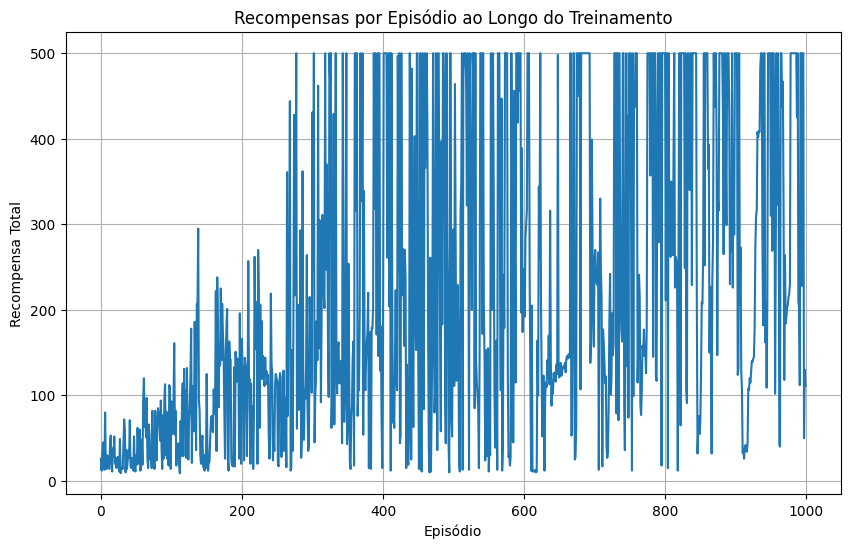



Recompensa média nos últimos 100 episódios: 298.83


In [26]:
plt.figure(figsize=(10, 6))
plt.plot(scores)
plt.title('Recompensas por Episódio ao Longo do Treinamento')
plt.xlabel('Episódio')
plt.ylabel('Recompensa Total')
plt.grid(True)
plt.show()

print(f"\n\nRecompensa média nos últimos 100 episódios: {np.mean(scores[-100:]):.2f}")

### 6.2 - Visualização do Agente em Ação

Para ver o agente treinado em ação, podemos renderizar um episódio e salvá-lo como vídeo. Execute a célula abaixo para gerar e exibir um vídeo do seu agente jogando CartPole.

**Observação:** A geração de vídeo pode levar alguns segundos e pode não funcionar em todos os ambientes (especialmente se não houver um display virtual configurado, como no Google Colab). Se estiver no Google Colab, a célula de "Configuração e Instalação de Dependências" já configurou o display virtual.

In [28]:
# Crie um ambiente com RecordVideo
env_video = RecordVideo(gym.make('CartPole-v1', render_mode='rgb_array'), video_folder="video")

# Redefina o ambiente para um novo episódio
state_video = env_video.reset()
done_video = False
truncated_video = False

# Execute o episódio
while not done_video:
    action_video = agent.get_action(state_video, epsilon=0.0) # Use epsilon=0.0 para explotação total
    state_video, reward_video, done_video, _ = env_video.step(int(action_video))

# Feche o ambiente de vídeo
env_video.close()

# Exiba o vídeo
show_video()

/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


## Conclusão

🎉 **Parabéns!** Você implementou e treinou um agente Double DQN para resolver o problema do CartPole. Você passou por todas as etapas, desde a definição da rede neural até o treinamento e a visualização dos resultados.

Este exercício é um passo fundamental para entender como os algoritmos de Aprendizagem por Reforço Profunda funcionam na prática. Continue explorando e construindo!

### Próximos Passos (Opcional):

- Experimente diferentes hiperparâmetros (taxa de aprendizado, fator de desconto, tamanho da memória, etc.).
- Modifique a arquitetura da `QNet` (mais camadas, diferentes funções de ativação).
- Tente aplicar o agente a outros ambientes simples do Gymnasium.
- Implemente outras melhorias do DQN, como Prioritized Experience Replay.